# Regression with DLT

In this notebook, we want to demonstartate how to use different arguments in **DLT** to train a model with various regression settings. We continue to use *iclaims* data for the demo purpose:

1. regular regression
2. regression with specific signs and priors for regression coefficients

Finally, we will also use a simulated dataset to illustrate different types of regression penalties:

1. `fixed-ridge`
2. `auto-ridge`
3. `lasso`

Generally speaking, regression coefficients are more robust under full Bayesian sampling and estimation.  Hence, we will use `DTLFull` in the session.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models.dlt import DLTFull, DLTMAP
from orbit.diagnostics.plot import plot_predicted_data
from orbit.constants.palette import QualitativePalette

from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [2]:
print(orbit.__version__)

1.0.14dev


## US Weekly Initial Claims

Recall the *iclaims* dataset by previous section. In order to use this data to nowcast the US unemployment claims during COVID-19 period, we extended the dataset to Jan 2021 and added the [S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1264032000&period2=1611187200&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) and [VIX](https://finance.yahoo.com/quote/%5EVIX/history?p=%5EVIX) Index historical data for the same period.

The data is standardized and log-transformed for the model fitting purpose.

In [3]:
# load data
df = load_iclaims(end_date='2021-01-03')
date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [4]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.016351,-0.345855,0.130569,-0.543044,0.082087
1,2010-01-10,13.624218,0.016351,-0.222241,0.181862,-0.550891,0.069878
2,2010-01-17,13.398741,0.032611,-0.319879,0.130569,-0.590640,0.491772
3,2010-01-24,13.137549,-0.000179,-0.222241,0.119987,-0.607162,0.388078
4,2010-01-31,13.196760,-0.069172,-0.269869,0.087552,-0.614339,0.446838


We can see form the plot below, there are seasonality, trend, and as well as a huge changpoint due the impact of COVID-19.

Text(0.5, 1.0, 'S&P500')

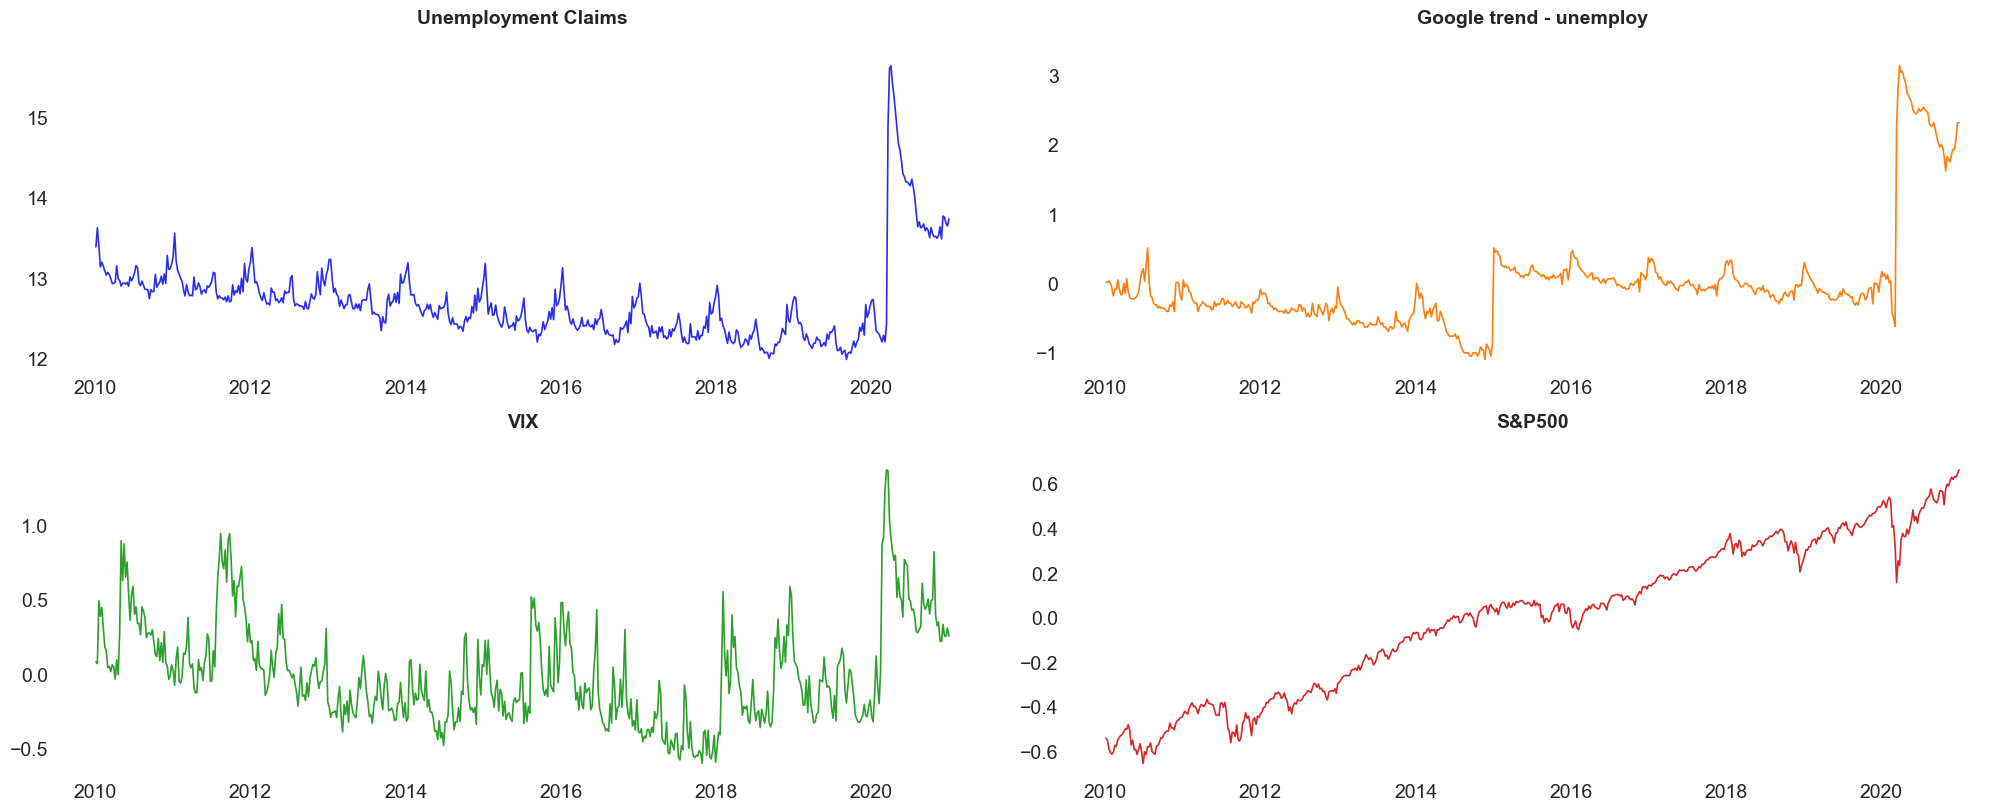

In [5]:
fig, axs = plt.subplots(2, 2,figsize=(20,8))
axs[0, 0].plot(df['week'], df['claims'])
axs[0, 0].set_title('Unemployment Claims')
axs[0, 1].plot(df['week'], df['trend.unemploy'], 'tab:orange')
axs[0, 1].set_title('Google trend - unemploy')
axs[1, 0].plot(df['week'], df['vix'], 'tab:green')
axs[1, 0].set_title('VIX')
axs[1, 1].plot(df['week'], df['sp500'], 'tab:red')
axs[1, 1].set_title('S&P500')

In [6]:
# using relatively updated data
df = df[df['week'] > '2018-01-01'].reset_index(drop=True)
test_size = 26
train_df = df[:-test_size]
test_df = df[-test_size:]

### Naive Model

Here we will use DLT models to compare the model performance with vs. without regression.

In [7]:
%%time
dlt = DLTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    num_warmup=4000,
)
dlt.fit(df=train_df)
predicted_df = dlt.predict(df=test_df)

CPU times: user 186 ms, sys: 102 ms, total: 288 ms
Wall time: 15.5 s


### DLT With Regression

The regressor columns can be supplied via argument `regressor_col`.  Recall the regression formula in **DLT**:

$$
\hat{y}_t =\mu_t + s_t + r_t \\
r_t = \sum_{j}\beta_j x_{jt} \\
\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)
$$

Let's use the default where $\mu_j = 0$ and $\sigma_j = 1$.  In addition, we can set a *sign* constraint for each coefficient $\beta_j$.  This is can be done by supplying the `regressor_sign` as a list where elements are in one of followings:

* '=': $\beta_j ~\sim \mathcal{N}(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, \inf)$
* '+': $\beta_j ~\sim \mathcal{N}^+(0, \sigma_j^2)$  i.e. $\beta_j \in [0, \inf)$
* '-': $\beta_j ~\sim \mathcal{N}^-(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, 0]$

Based on some intuition, it's reasonable to assume search terms such as "unemployment", "filling" and **VIX** index to be positively correlated and stock index such as **SP500** to be negatively correlated to the outcome.  Then we will leave whatever unsured as a regular regressor.

In [8]:
%%time
dlt_reg = DLTFull(
    response_col=response_col, 
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job', 'sp500', 'vix'],
    regressor_sign=["+", '+', '=', '-', '+'], 
    seasonality=52,
    seed=8888,
    num_warmup=4000,
)
dlt_reg.fit(df=train_df)
predicted_df_reg = dlt_reg.predict(test_df)

CPU times: user 173 ms, sys: 91.5 ms, total: 265 ms
Wall time: 16.2 s


The estimated regressor coefficients can be retrieved via `.get_regression_coefs()`.

In [9]:
dlt_reg.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.114867
1,trend.filling,Positive,0.214489
2,vix,Positive,0.042072
3,sp500,Negative,-0.356029
4,trend.job,Regular,0.021419


### DLT with Regression and Informative Priors

Assuming users obtain further knowledge on some of the regressors, they could use informative priors ($\mu$, $\sigma$) by replacing the defaults. This can be done via the arguments `regressor_beta_prior` and `regressor_sigma_prior`. These two lists should be of the same lenght as `regressor_col`.

In [10]:
dlt_reg_adjust = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job', 'sp500', 'vix'],
    regressor_sign=["+", '+', '=', '-', '+'], 
    regressor_beta_prior=[0.5, 0.25, 0.07, -0.3, 0.03],
    regressor_sigma_prior=[0.1] * 5,
    seasonality=52,
    seed=8888,
    num_warmup=4000,
)
dlt_reg_adjust.fit(df=train_df)
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df)

In [11]:
dlt_reg_adjust.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.309913
1,trend.filling,Positive,0.258088
2,vix,Positive,0.052401
3,sp500,Negative,-0.284201
4,trend.job,Regular,0.047232


Let's compare the holdout performance by using the built-in function `smape()` .

In [12]:
import numpy as np
from orbit.diagnostics.metrics import smape

# to reverse the log-transformation
def smape_adjusted(x, y):
    x = np.exp(x)
    y = np.exp(y)
    return smape(x, y)

naive_smape = smape_adjusted(predicted_df['prediction'].values, test_df['claims'].values)
reg_smape = smape_adjusted(predicted_df_reg['prediction'].values, test_df['claims'].values)
reg_adjust_smape = smape_adjusted(predicted_df_reg_adjust['prediction'].values, test_df['claims'].values)

print('Naive Model: {:.3f}\nRegression Model: {:.3f}\nRefined Regression Model: {:.3f}'.format(
    naive_smape, reg_smape, reg_adjust_smape
))

Naive Model: 0.205
Regression Model: 0.153
Refined Regression Model: 0.089


## Regression on Simulated Dataset

Let's use a simulated dateset to demonstrate sparse regression.

In [13]:
import pandas as pd

from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_trend, make_regression
from orbit.diagnostics.metrics import mse

We have developed a few utilites to generate simulated data. For details, please refer to our API doc.  In brief, we are generating observations $y$ such that

$$y_t = l_t + r_t $$

where

$$r_t = \sum_p^{P} \beta_p  x_{p,t}$$

### Regular Regression

Let's start with a small number of regressors with $P=10$ and $T=100$.

In [14]:
NUM_OF_REGRESSORS = 10
SERIES_LEN = 50
SEED = 20210101
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
print(regression.shape, x.shape)

(50,) (50, 10)


In [15]:
# combine trend and the regression
y = trend + regression

In [16]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
df.shape

(50, 12)

Let's take a peek on the coefficients.

In [17]:
coefs

array([ 0.38372743, -0.21084054,  0.5404565 , -0.21864409,  0.85529298,
       -0.83838077, -0.54550632,  0.80367924, -0.74643654, -0.26626975])

Now, let's run a regression with the defaults where we have constant `regressor_sigma_prior` and `regression_penalty` set as `fixed-ridge`.

#### Fixed Ridge Penalty

In [18]:
%%time
dlt_fridge = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seed=SEED,
    # this is default
    regression_penalty='fixed_ridge',
    # fixing the smoothing parameters to learn regression coefficients more effectively
    level_sm_input=0.01,
    slope_sm_input=0.01,
    num_warmup=4000,
)
dlt_fridge.fit(df=df)

CPU times: user 63.8 ms, sys: 55.7 ms, total: 119 ms
Wall time: 2.25 s


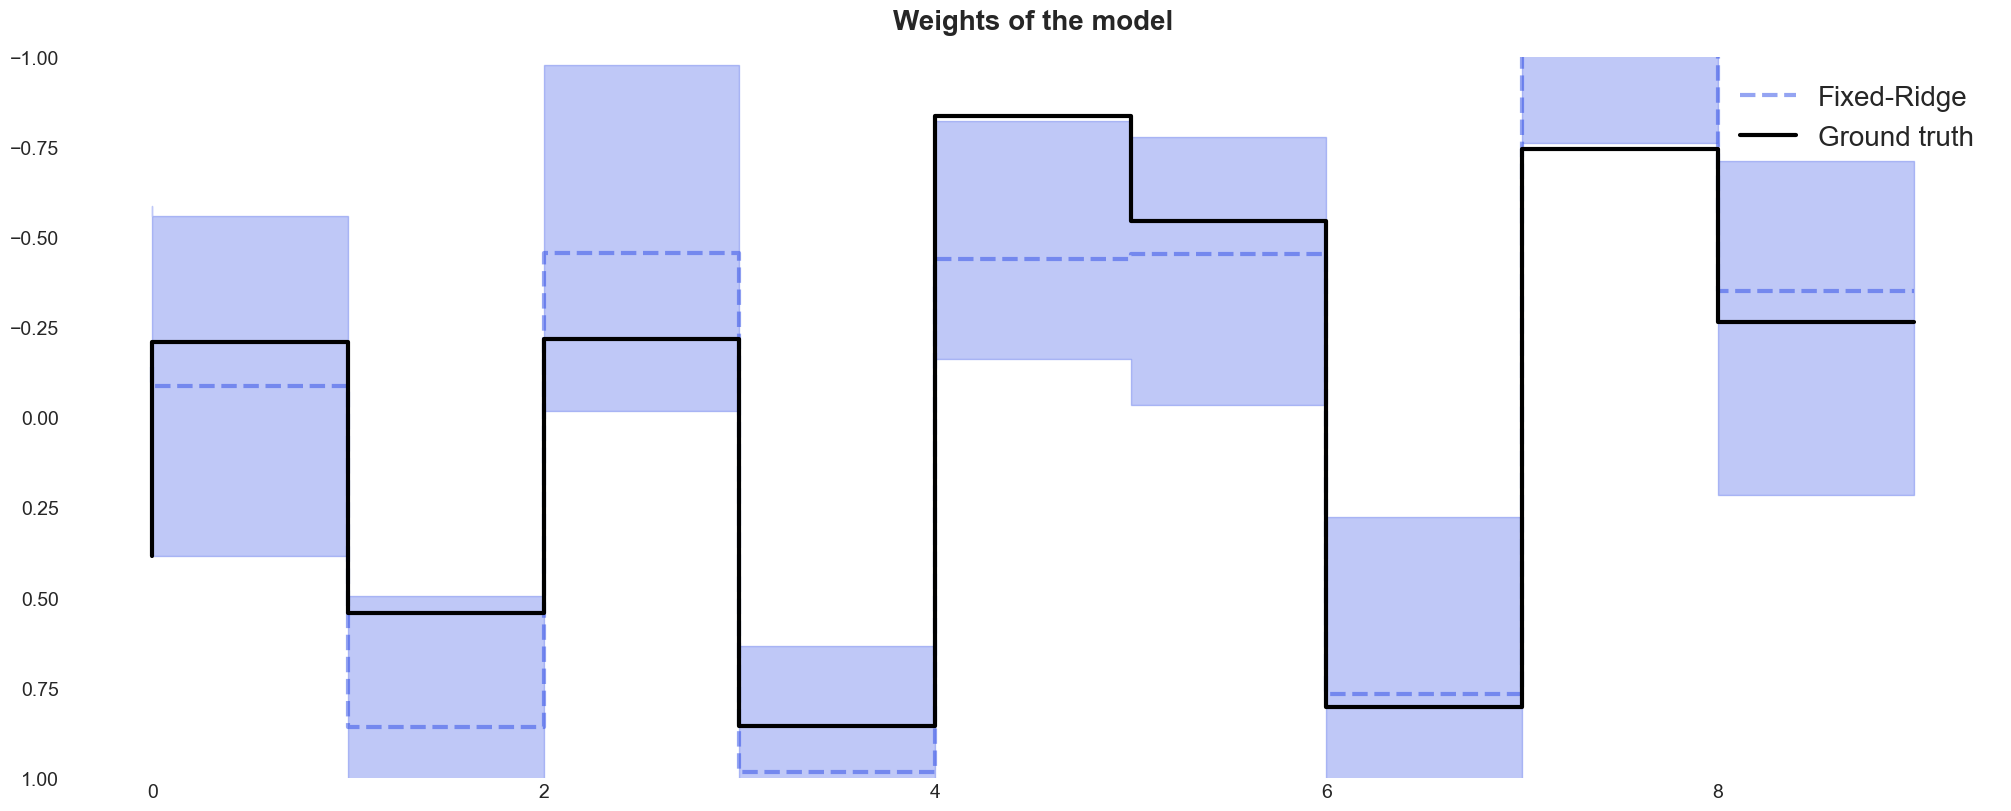

In [19]:
coef_fridge = np.quantile(dlt_fridge._posterior_samples['beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model", fontsize=20)
plt.plot(idx, coef_fridge[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label='Fixed-Ridge', alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_fridge[0], coef_fridge[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend(prop={'size': 20})
plt.grid()

We can also set the `regression_penalty` to be `auto-ridge` in case we are sure what to set for the `regressor_sigma_prior`.

#### Auto-Ridge Penalty

Instead of using fixed scale in the coefficients prior, a hyperprior can be assigned to them, i.e.

$$ \sigma_j \sim \text{Cauchy}^{+} {(0, \alpha)} $$

This can be done by setting `regression_penalty="auto_ridge"` with the argument `auto_ridge_scale` (default of `0.5`) set the hyperprior $\alpha$. We can also supply stan config such as `adapt_delta` to reduce divergence.  Check the [here](https://mc-stan.org/rstanarm/reference/adapt_delta.html) for details of `adapt_delta`.

In [20]:
%%time
dlt_auto_ridge = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seed=SEED,
    # this is default
    regression_penalty='auto_ridge',
    # fixing the smoothing parameters to learn regression coefficients more effectively
    level_sm_input=0.01,
    slope_sm_input=0.01,
    num_warmup=4000,
    # reduce divergence 
    stan_mcmc_control={'adapt_delta':0.9},
)
dlt_auto_ridge.fit(df=df)

CPU times: user 69.3 ms, sys: 55.9 ms, total: 125 ms
Wall time: 5.1 s


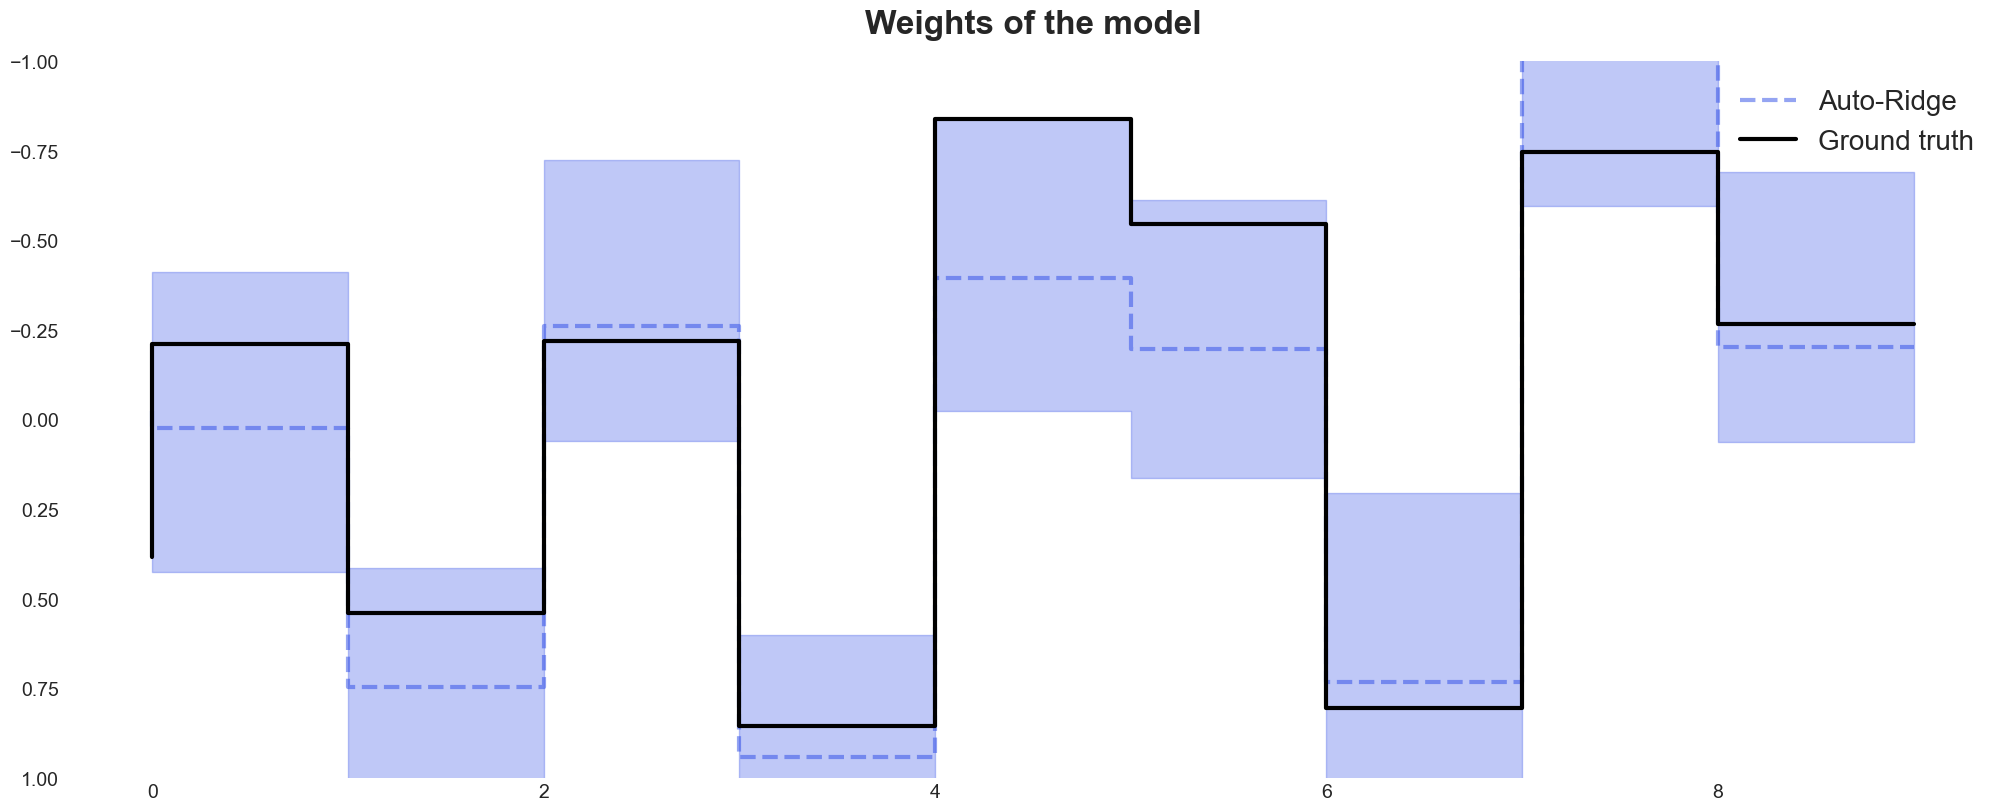

In [21]:
coef_auto_ridge = np.quantile(dlt_auto_ridge._posterior_samples['beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model", fontsize=24)
plt.plot(idx, coef_auto_ridge[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label='Auto-Ridge', alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_auto_ridge[0], coef_auto_ridge[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend(prop={'size': 20})
plt.grid();

In [22]:
print('Fixed Ridge MSE:{:.3f}\nAuto Ridge MSE:{:.3f}'.format(
    mse(coef_fridge[1], coefs), mse(coef_auto_ridge[1], coefs)
))

Fixed Ridge MSE:0.082
Auto Ridge MSE:0.079


### Sparse Regrssion

Now, let's move to a challenging problem with a much higher $P$ to $N$ ratio with a sparsity specified by the parameter `relevance=0.5` under the simulation process.

In [23]:
NUM_OF_REGRESSORS = 50
SERIES_LEN = 50
SEED = 20210101
COEFS = np.random.default_rng(SEED).uniform(0.3, 0.5, NUM_OF_REGRESSORS)
SIGNS = np.random.default_rng(SEED).choice([1, -1], NUM_OF_REGRESSORS)
# to mimic a either zero or relative observable coefficients
COEFS = COEFS * SIGNS
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS, relevance=0.5)
print(regression.shape, x.shape)

(50,) (50, 50)


In [24]:
# generated sparsed coefficients
coefs

array([ 0.        ,  0.        , -0.45404565,  0.37813559,  0.        ,
        0.        ,  0.        ,  0.48036792, -0.32535635, -0.37337302,
       -0.42474576,  0.        , -0.37000755,  0.44887456,  0.47082836,
        0.        ,  0.32678039,  0.37436121,  0.38932392,  0.40216056,
        0.        ,  0.        , -0.3076828 , -0.35036047,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.45838674,  0.3171478 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.41599814,  0.        , -0.30964341,
       -0.42072894,  0.36255583,  0.        , -0.39326337,  0.44455655,
        0.        ,  0.        ,  0.30064161, -0.46083203,  0.        ])

In [25]:
# combine trend and the regression
y = trend + regression

In [26]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
df.shape

(50, 52)

### Fixed Ridge Penalty

In [27]:
dlt_fridge = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seed=SEED,
    level_sm_input=0.01,
    slope_sm_input=0.01,
    num_warmup=8000,
)
dlt_fridge.fit(df=df)

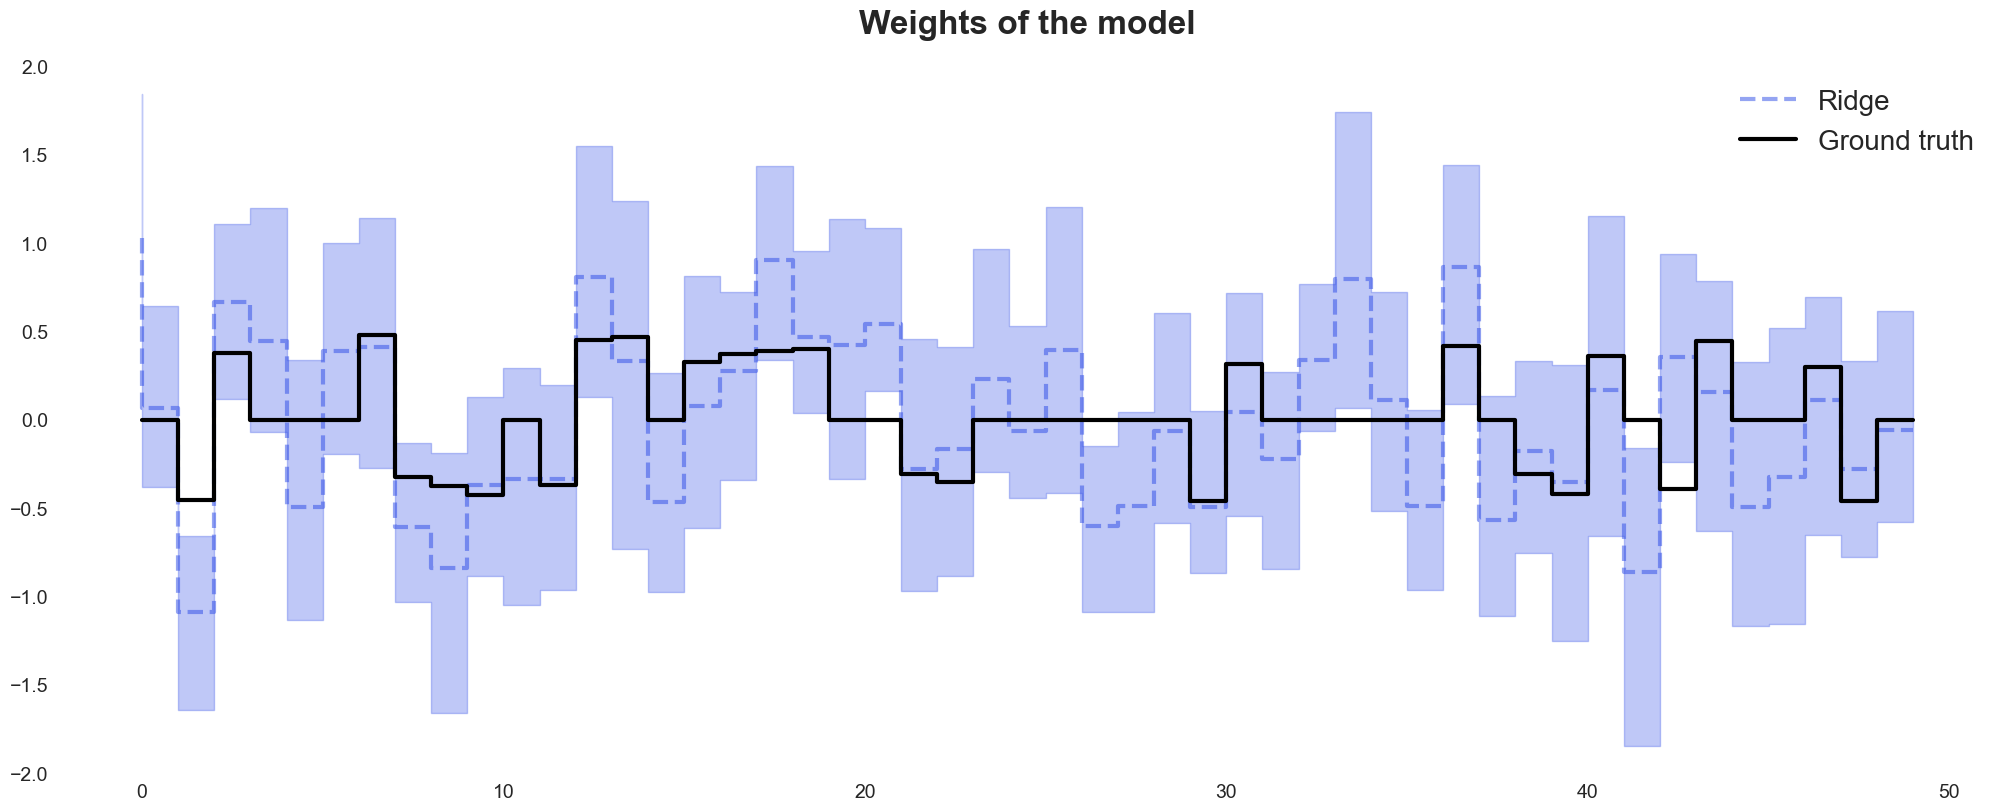

In [28]:
coef_fridge = np.quantile(dlt_fridge._posterior_samples['beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model", fontsize=24)
plt.plot(coef_fridge[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Ridge", alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_fridge[0], coef_fridge[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.legend(prop={'size': 20})
plt.grid();

#### LASSO  Penalty

In high $P$ to $N$ problems, *LASS0* penalty usually shines compared to *Ridge* penalty.

In [29]:
dlt_lasso = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seed=SEED,
    regression_penalty='lasso',
    level_sm_input=0.01,
    slope_sm_input=0.01,
    num_warmup=8000,
)
dlt_lasso.fit(df=df)

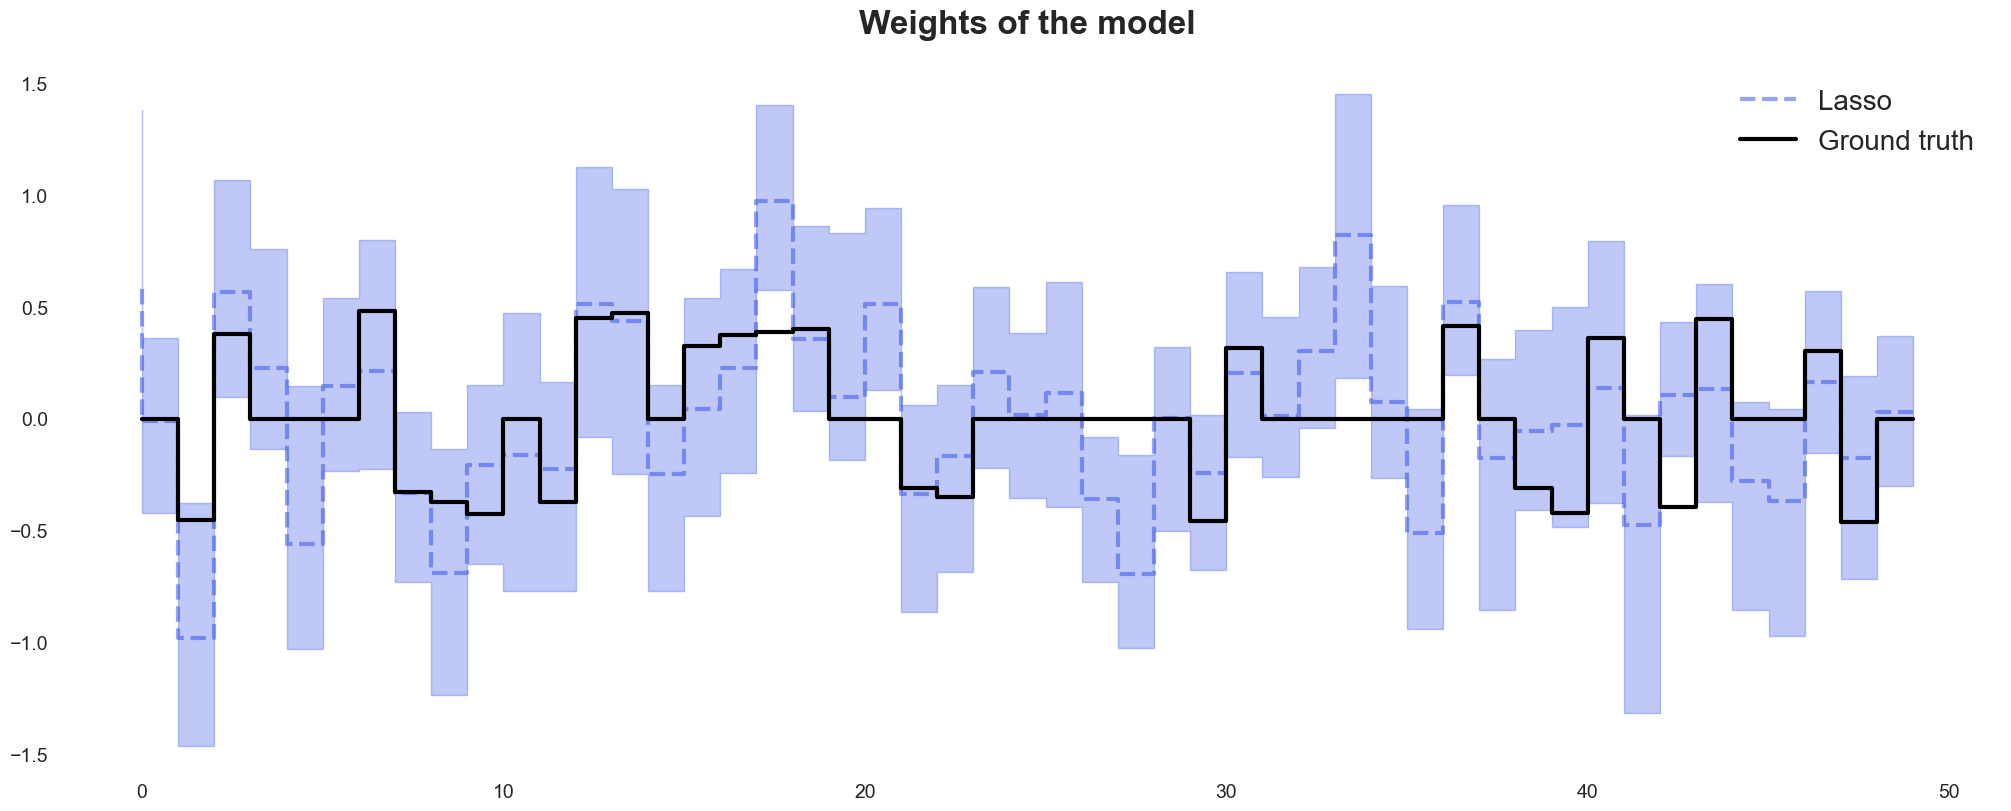

In [30]:
coef_lasso = np.quantile(dlt_lasso._posterior_samples['beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model", fontsize=24)
plt.plot(coef_lasso[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Lasso", alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_lasso[0], coef_lasso[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.legend(prop={'size': 20})
plt.grid();

In [31]:
print('Fixed Ridge MSE:{:.3f}\nLASSO MSE:{:.3f}'.format(
    mse(coef_fridge[1], coefs), mse(coef_lasso[1], coefs)
))

Fixed Ridge MSE:0.162
LASSO MSE:0.102
